## Configuración de paquetes base

In [ ]:
## General modules
import pandas as pd
import numpy as np
import time
import os
from scipy import stats as sp_stats
from sklearn.model_selection import train_test_split
import shutil
from google.colab import drive
import matplotlib.pyplot as plt
from random import shuffle, seed
from sklearn.model_selection import ParameterGrid

## Calibration modules
from sklearn import metrics
from sklearn import calibration

## Neural networks
import keras 
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model, Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import utils, applications
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
## GoogleDrive Connection
drive.mount('/content/drive')

Mounted at /content/drive


## Configuración de paquetes de Github

In [ ]:
## Instal QMC package
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install git+https://github.com/fagonzalezo/qmc.git
else:
    import sys
    sys.path.insert(0, "../")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fagonzalezo/qmc.git to /tmp/pip-req-build-mjzm0mkg
  Running command git clone --filter=blob:none --quiet https://github.com/fagonzalezo/qmc.git /tmp/pip-req-build-mjzm0mkg
  Resolved https://github.com/fagonzalezo/qmc.git to commit 8fa763aa84e1d9de80352a115dd0b0de815a726b
  Preparing metadata (setup.py) ... done
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12755 sha256=a3ed2fd5b50bf43f0a54c25d0bdd64b1a05f0a168783213087f7bb41a2719d29
  Stored in directory: /tmp/pip-ephem-wheel-cache-jrq6toy5/wheels/bd/29/aa/e718040fd08e50166362474405988f9b9a9f8b2db6a7d75ed5
Successfully built qmc


In [ ]:
## Install calibration package
!pip install git+https://github.com/uu-sml/calibration.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/uu-sml/calibration.git to /tmp/pip-req-build-yccdnctd
  Running command git clone --filter=blob:none --quiet https://github.com/uu-sml/calibration.git /tmp/pip-req-build-yccdnctd
  Resolved https://github.com/uu-sml/calibration.git to commit 7bd1a2407f96f87e37d81eadaea7efeb14bb8a83
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.1 MB/s eta 0:00:00
  Created wheel for calibration: filename=calibration-0.0.1-py3-none-any.whl size=16891 sha256=826f1e4b112f3a2685a55f9fdd7551fe17c49bd83af3db70884bd3b955e04525
  Stored in directory: /tmp/pip-ephem-wheel-cache-vdv8kqjz/wheels/ea/67/e0/9f3de41456f07fb81268b88a9adad2069f4fc3b7dcab126433
Successfully built calibration


El paquete de _calibration_ tal cual como viene de github, no trae la carpeta de _utils_ donde están las distancias que se pueden utilizar. Adicionalmente, la inicialización del paquete no contiene nada, por lo cual se debe solucionar este problema con los siguientes.

In [ ]:
## Path in where files to fix clone of calibration module are
path_in = "/content/drive/MyDrive/Trabajo de Grado Maestría/Librería Calibration/"

## Path out where files to fix clone of calibration module have to be
path_out = "/usr/local/lib/python3.8/dist-packages/calibration/"

## Create folder 
if not os.path.isdir(path_out + "utils"):
  os.mkdir(path_out + "utils")

## Copy files
shutil.copyfile(path_in + "distances.py", path_out + "utils/distances.py")
shutil.copyfile(path_in + "__init__.py", path_out + "utils/__init__.py")

'/usr/local/lib/python3.8/dist-packages/calibration/utils/__init__.py'

In [ ]:
## Calibration functions
import calibration.stats as cali_stats
import calibration.utils as cali_utils
import calibration.binning as cali_binning
import calibration.sample as cali_sample
import calibration.lenses as cali_lenses 

In [ ]:
## QUMC functions
import qmc.tf.layers as layers
import qmc.tf.models as models

## Calibration functions

In [ ]:
#===================================#
#     Class-wise ECE for tensors    #    
#===================================#
def cwECE_tf(y_true, y_pred):
  n_bins = 15
  
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = 0.0

  ## Calculate ECE for each class
  for k in range(y_pred.shape[1]):
    ## Store probs and observations
    confidences = y_pred[:,k]
    accuracies = y_pred[:,k] == 1

    ece = 0.0
    # ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
      prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

      if prop_in_bin > 0:
          accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
          avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
          ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    ## Store values 
    ece_list += ece

  ece_list = ece_list/y_pred.shape[1]

  return ece_list

#========================================#
#   Maximum confidence ECE for tensors   #
#========================================#
def maxECE_tf(y_true, y_pred):
  n_bins = 15

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = tf.math.reduce_max(y_pred, axis = 1)
  predictions = tf.math.argmax(y_pred, axis = 1)
  accuracies = predictions == tf.math.argmax(y_true, axis = 1)

  ## Confidence and predictions in each bin
  ece = 0.0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
    prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

    if prop_in_bin > 0:
        accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
        avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
        ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      
  return ece

#================================#
#          Class-wise ECE        #
#================================#
def cwECE(n_bins, probs, obs, metric):
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = []

  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Calculate ECE for each class
  for k in range(probs.shape[1]):
    
    ## Store probs and observations
    confidences = probs[:,k]
    accuracies = obs[:,k] == 1

    ## Lists to store values to plot the reliability diagram
    conf = []
    acc = []
    bin = []

    ece = 0
    ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):       
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower)*(confidences <= bin_upper)      
      prop_in_bin = np.mean(in_bin)
      if prop_in_bin > 0:
        accuracy_in_bin = np.mean(accuracies[in_bin])
        avg_confidence_in_bin = np.mean(confidences[in_bin])
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        conf += [avg_confidence_in_bin]
        acc += [accuracy_in_bin]
        bin += [(bin_lower + bin_upper)/2]        
        del in_bin, prop_in_bin, accuracy_in_bin, avg_confidence_in_bin
    ## Store values
    conf_list += [conf]
    acc_list += [acc]
    bin_list += [bin]    
    ece_list += [ece]
    del conf, acc, bin, ece
  
  if metric is True:
    return np.mean(ece_list)
  else:
    return ece_list, conf_list, acc_list, bin_list

#================================#
#    Maximum confidence ECE      #
#================================#
def maxECE(n_bins, probs, obs, metric):
  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = probs.max(axis = 1)
  predictions = probs.argmax(axis = 1)
  accuracies = probs.argmax(axis = 1) == obs.argmax(axis = 1)

  ## Confidence and predictions in each bin
  ece = 0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower)*(confidences <= bin_upper)
    prop_in_bin = np.mean(in_bin)  

    if prop_in_bin > 0:
      accuracy_in_bin = np.mean(accuracies[in_bin])
      avg_confidence_in_bin = np.mean(confidences[in_bin])
      ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      conf_list += [avg_confidence_in_bin]
      acc_list += [accuracy_in_bin]
      bin_list += [(bin_lower + bin_upper)/2]   

  if metric is True:
    return ece
  else: 
    return ece, conf_list, acc_list, bin_list

#========================#
#   Brier multiclass     #
#========================#
def brier_multi(targets, probs):
  """ 
  targets: Numpy array of one-hot encoding of observed labels with shape (n, classes)
  probs: Numpy array of probs for each class with shape (n, classes)
  """
  return np.mean(np.sum((probs - targets)**2, axis = 1))

#================================================#
#   Function to calculate calibration metrics    #
#================================================#
def resume_metrics(X_test, Y_test, T_test, model, nbins, p_value):
  """
  Arguments:
    X_test    : Covariates for testing (n,p)
    Y_test    : Target variable dimension for testing (n,)
    T_test    : One hot encoding of the target variable dimension for testing (n,c)
    p_value   : Whether it should be done the resampling to obtain the p-value of ece metrics

    model     : Model object that contains .predict function to obtain the probabilities for each class    
    nbins     : Number of equally sized bins created

  where: 
    c: Number of classes
    p: number of covariates
    n: Number of observations

  It returns a tuple with pandas data.frames with results of calibration metrics 
  """
  
  #==============================================#
  #                 Organize data                #
  #==============================================#
  ## Predictions on test
  pred_test = model.predict(X_test)
  
  ## Most confident probability predictions (Maximum lenses)
  pred_test_max, T_test_max = cali_lenses.maximum_lens(probs = pred_test, y = T_test)

  #=============================================================================#
  #                  Expected Calibration Error                                 #
  #=============================================================================#
  ## Cambiar nombres
  ## ECE + dependent binning + tvdistance
  ece_max_uni = cali_stats.ece(probs = pred_test_max, 
                              y = T_test_max,
                              distance = cali_utils.tvdistance, 
                              binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean"))

  ## ECE + uniform binning + tvdistance
  ece_max_dep = cali_stats.ece(probs = pred_test_max, 
                              y = T_test_max,
                              distance = cali_utils.tvdistance, 
                              binning = cali_binning.UniformBinning(bins = nbins))

  ## cwECE + uniform binning
  ece_cw_uni = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = True)

  #======================================================#
  #       Samples under perfect calibration (ECE)        #
  #======================================================#

  if p_value:
    np.random.seed(6164)
    ## ECE + dependent binning + tvdistance
    # Define Resampling
    resample = cali_sample.ResampleStats(
        lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance,
                                binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean")),
                                n = 1000)
    
    # Generate samples
    ece_max_dep_sample = resample(pred_test_max)
    del resample

    ## ECE + uniform binning + tvdistance
    # Define Resampling
    resample = cali_sample.ResampleStats(
        lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance, 
                                binning = cali_binning.UniformBinning(bins = nbins)),
                                n = 1000)

    # Generate samples
    ece_max_uni_sample = resample(pred_test_max)
    del resample

    ## cw-ECE + uniform binning
    # Define Resampling
    resample = cali_sample.ResampleStats(lambda x: cwECE(n_bins = nbins, probs = x, obs = T_test, metric = True), n = 1000)

    # Generate samples
    ece_cw_uni_sample = resample(pred_test)

    #====================================================================#
    #    P-value of ECE under assumption of perfect calibration (ECE)    #
    #====================================================================#
    ## Data dependent binning + tv distance
    p_data_max = 1 - sp_stats.percentileofscore(ece_max_dep_sample, ece_max_dep)/100

    ## Uniform binning + tv distance
    p_uni_max = 1 - sp_stats.percentileofscore(ece_max_uni_sample, ece_max_uni)/100

    ## Uniform binning + tv distance
    p_uni_cw = 1 - sp_stats.percentileofscore(ece_cw_uni_sample, ece_cw_uni)/100
  
  #==================================#
  #          Brier score             #
  #==================================#  
  ## Brier for all classes
  bri_full = brier_multi(targets = T_test, probs = pred_test)

  ## Brier for most confidence class
  bri_max = brier_multi(targets = T_test_max, probs = pred_test_max)

  #===========================#
  #           Log Loss        #
  #===========================#
  loss_full = metrics.log_loss(y_true = T_test, y_pred = pred_test)
  loss_maxx = metrics.log_loss(y_true = T_test_max, y_pred = pred_test_max)

  #=================================================#
  #                 Reliability Diagram             #
  #=================================================#
  ## Class-wise reliability diagram and ECE individually
  cw_ece_list, cw_conf_list, cw_acc_list, cw_bin_list = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = False)

  ## Most confident prediction 
  max_ece, max_conf_list, max_acc_list, max_bin_list = maxECE(n_bins = nbins, probs = pred_test_max, obs = T_test_max, metric = False)

  ## Organize data
  diag_cw = pd.DataFrame({"ece" : cw_ece_list, "conf" : cw_conf_list, "acc" : cw_acc_list, "bin" : cw_bin_list})
  diag_max = pd.DataFrame({"ece" : max_ece, "conf" : max_conf_list, "acc" : max_acc_list, "bin" : max_bin_list})

  #=============================#
  #   Combine all the results   #
  #=============================#
  if p_value:
    ## Combine results
    global_metrics_ece = pd.DataFrame({
        "Approach" : ["Maximum","Maximum","CW"],
        "Distance" : ["TV","TV","-"],
        "Binning" : ["Data","Uniform","Uniform"],
        "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
        "ECE perfcect mean" : [np.mean(ece_max_dep_sample), np.mean(ece_max_uni_sample), np.mean(ece_cw_uni_sample) ],
        "ECE perfcect std" : [np.std(ece_max_dep_sample), np.std(ece_max_uni_sample), np.std(ece_cw_uni_sample) ],
        "ECE p-value" : [p_data_max, p_uni_max, p_uni_cw] })
  else: 
        ## Combine results
    global_metrics_ece = pd.DataFrame({
        "Approach" : ["Maximum","Maximum","CW"],
        "Distance" : ["TV","TV","-"],
        "Binning" : ["Data","Uniform","Uniform"],
        "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
        "ECE perfcect mean" : [np.nan, np.nan, np.nan ],
        "ECE perfcect std" : [np.nan, np.nan, np.nan ],
        "ECE p-value" : [np.nan, np.nan, np.nan ] })
  
  global_metrics = pd.DataFrame({
      "Brier_full" : [bri_full],
      "Brier_maximum" : [bri_max],
      "Log-loss_full" : [loss_full],
      "Log-loss_maximum" : [loss_maxx] })
  
  return global_metrics, global_metrics_ece, diag_max, diag_cw


#=====================================================================#
#           Function to plot the results of the optimization          #
#=====================================================================#
def GraphOptimizationMetrics(df_metrics, df_metrics_ece):
  """  
  This functions plot the results of global and calibration metrics output of resume_metrics.

  df_metrics: It is a pandas dataframe that corresponds to the "gm" object
  df_metrics_ece: It is a pandas dataframe that corresponds to the "gm_ece" object

  Output a grid of plots with some of the results
  """
  ## Subset data
  ece_cw = df_metrics_ece.loc[df_metrics_ece["Approach"] == "CW",:]
  ece_max_u = df_metrics_ece.loc[(df_metrics_ece["Approach"] == "Maximum") & (df_metrics_ece["Binning"] == "Uniform"),:]
  ece_max_d = df_metrics_ece.loc[(df_metrics_ece["Approach"] == "Maximum") & (df_metrics_ece["Binning"] == "Data"),:]

  ## Format for ticks
  majorFormatter = FormatStrFormatter('%0.1f')

  ## Color map for heatmaps
  color_map = "flare_r"

  fig, axis = plt.subplots(2, 4, figsize = (20,8))


  ##====== Log-loss
  sns.heatmap(df_metrics.pivot("dim_rff", "gamma_rff", "Log-loss_full"),                         
              ax = axis[0,0],
              cmap = color_map,
              cbar_kws={'label': ''})

  axis[0,0].set_xlabel("Gamma")
  axis[0,0].set_ylabel("Dimension")
  axis[0,0].set_title("Log-loss (Validation)")
  axis[0,0].xaxis.set_major_formatter(majorFormatter)
  axis[0,0].tick_params(axis='y', which = 'major', rotation = 0)

  ##====== Accuracy train
  sns.heatmap(df_metrics.pivot("dim_rff", "gamma_rff", "acc_train"),             
              cmap = color_map.replace("_r",""),
              ax = axis[0,1],
              cbar_kws={'label': ''})

  axis[0,1].set_xlabel("Gamma")
  axis[0,1].set_ylabel("Dimension")
  axis[0,1].set_title("Accuracy (Training)")
  axis[0,1].xaxis.set_major_formatter(majorFormatter)
  axis[0,1].tick_params(axis='y', which = 'major', rotation = 0)

  ##====== Accuracy validation
  sns.heatmap(df_metrics.pivot("dim_rff", "gamma_rff", "acc_val"),             
              cmap = color_map.replace("_r",""),
              ax = axis[0,2],
              cbar_kws={'label': ''})

  axis[0,2].set_xlabel("Gamma")
  axis[0,2].set_ylabel("Dimension")
  axis[0,2].set_title("Accuracy (Validation)")
  axis[0,2].xaxis.set_major_formatter(majorFormatter)
  axis[0,2].tick_params(axis='y', which = 'major', rotation = 0)

  ##====== Blank plot
  axis[0,3].set_visible(False)

  ##====== Brier
  sns.heatmap(df_metrics.pivot("dim_rff", "gamma_rff", "Brier_full"),             
              cmap = color_map,
              ax = axis[1,0],
              cbar_kws={'label': ''})

  axis[1,0].set_xlabel("Gamma")
  axis[1,0].set_ylabel("Dimension")
  axis[1,0].set_title("Brier Score (Validation)")
  axis[1,0].xaxis.set_major_formatter(majorFormatter)
  axis[1,0].tick_params(axis='y', which = 'major', rotation = 0)

  ##====== ECE uniform
  sns.heatmap(ece_max_u.pivot("dim_rff", "gamma_rff", "ECE observed"), 
              cmap = color_map,
              ax = axis[1,1],
              cbar_kws={'label': ''})

  axis[1,1].set_xlabel("Gamma")
  axis[1,1].set_ylabel("Dimension")
  axis[1,1].set_title("Max-ECE uniform\n(Validation)")
  axis[1,1].xaxis.set_major_formatter(majorFormatter)
  axis[1,1].yaxis.set_major_formatter(majorFormatter)
  axis[1,1].tick_params(axis='y', which = 'major', rotation = 0)

  ##====== ECE data
  sns.heatmap(ece_max_d.pivot("dim_rff", "gamma_rff", "ECE observed"), 
              cmap = color_map,
              ax = axis[1,2],
              cbar_kws={'label': ''})

  axis[1,2].set_xlabel("Gamma")
  axis[1,2].set_ylabel("Dimension")
  axis[1,2].set_title("Max-ECE data\n(Validation)")
  axis[1,2].xaxis.set_major_formatter(majorFormatter)
  axis[1,2].yaxis.set_major_formatter(majorFormatter)
  axis[1,2].tick_params(axis='y', which = 'major', rotation = 0)

  ##====== CW-ECE
  sns.heatmap(ece_cw.pivot("dim_rff", "gamma_rff", "ECE observed"), 
              cmap = color_map,
              ax = axis[1,3],
              cbar_kws={'label': ''})

  axis[1,3].set_xlabel("Gamma")
  axis[1,3].set_ylabel("Dimension")
  axis[1,3].set_title("CW-ECE\n(Validation)")
  axis[1,3].xaxis.set_major_formatter(majorFormatter)
  axis[1,3].yaxis.set_major_formatter(majorFormatter)
  axis[1,3].tick_params(axis='y', which = 'major', rotation = 0)

  ## Adjust space between plots
  fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
  plt.show()

  return print("Done")

#=================================================#
#                      Reliability function       #
#=================================================#
def ReliabilityDiagram(df_gram, diagram, nr_plt, nc_plt, w_plt, h_plt):
  """ 
  Function to plot the reliability diagram for the most confident prediction or
  for the class-wise results.

  df_gram: Pandas dataframe with the data to plot
  diagram: Whether "max" or "cw" reliability diagram
  nr_plt: Number of row plots for the classwise option
  nc_plt: Number of column plots for the classwise option
  w_plt: Size of the width of the figure
  h_plt: Size of the height of the figure
  """

  ##=========== Reliability diagram (most confident prediction)
  if diagram == "max":
    dd = df_gram
    ece = np.round(df_gram.loc[:,"ece"].tolist()[0],4)
    n_bins = 15

    plt.figure(figsize = (w_plt, h_plt))

    plt.plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
    plt.bar(dd["bin"], dd["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
    plt.text(0.05, 0.9, f"ECE: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
    plt.ylabel("Exactitud promedio") # "Average Accuracy" 
    plt.xlabel("Confianza promedio") # "Average Confidence"
    plt.title("", fontsize = 18)

    # plt.show()

  ##=========== Reliability diagram (classwise)
  if diagram == "cw":
    dd = df_gram
    n_bins = 15

    fig, ax = plt.subplots(nr_plt, nc_plt, sharey = True, sharex = True, figsize = (w_plt, h_plt))

    if nr_plt == 1:
      for i in range(nc_plt):
        ece = np.round(df_gram.iloc[i,:]["ece"],4)

        ax[i].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
        ax[i].bar(dd.iloc[i,:]["bin"], dd.iloc[i,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
        ax[i].set_title(f"Class {str(i)}")
        ax[i].text(0.05, 0.9, f"cwECE: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
        ax[i].set_ylabel("Exactitud promedio") # Average Accuracy
        ax[i].set_xlabel()
    else:
      c = 0
      for i in range(nr_plt):
        for j in range(nc_plt):
          if c < dd.shape[0]:
            ece = np.round(df_gram.iloc[c,:]["ece"],4)

            ax[i,j].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
            ax[i,j].bar(dd.iloc[c,:]["bin"], dd.iloc[c,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
            ax[i,j].set_title(f"Class {str(c)}")
            ax[i,j].text(0.05, 0.9, f"cwECE: {ece}", bbox={'facecolor' : "white",'alpha': 1, 'pad': 10})
            ax[i,j].set_ylabel("Exactitud promedio") # "Average Accuracy"
            ax[i,j].set_xlabel("Confianza promedio") # "Average Confidence"
            c += 1        
          else:
            ax[i,j].set_visible(False)

    fig.suptitle("", fontsize = 20)
    fig.show()

  return None

## Carga datos CIFAR-10

In [ ]:
#====================#
#      Load data     #
#====================#
## Load data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

## Normalize data
X_train = X_train/255
X_test = X_test/255

## Sustract mean
x_train_mean = np.mean(X_train, axis = 0)
train_mean = x_train_mean
X_train -= train_mean
X_test -= train_mean

## Reshape data 
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

## Train-validation split
X_dev, X_val, Y_dev, Y_val = train_test_split(X_train, Y_train, test_size = 0.10, shuffle = True, random_state = 2019) 

## Get columns in classes as dummies
T_test = pd.get_dummies(Y_test).values
T_dev = pd.get_dummies(Y_dev).values
T_val = pd.get_dummies(Y_val).values

del x_train_mean

## Print shapes
print("Shape X train + validation: ", X_train.shape)
print("Shape Y train + validation: ", Y_train.shape, "\n")
print("Shape X train: ", X_dev.shape)
print("Shape Y train: ", Y_dev.shape, "\n")
print("Shape X validation: ", X_val.shape)
print("Shape Y validation: ", Y_val.shape, "\n")
print("Shape Y test: ", Y_test.shape)
print("Shape X test: ", X_test.shape)

170498071/170498071 [==============================] - 6s 0us/step
Shape X train + validation:  (50000, 32, 32, 3)
Shape Y train + validation:  (50000,) 

Shape X train:  (45000, 32, 32, 3)
Shape Y train:  (45000,) 

Shape X validation:  (5000, 32, 32, 3)
Shape Y validation:  (5000,) 

Shape Y test:  (10000,)
Shape X test:  (10000, 32, 32, 3)


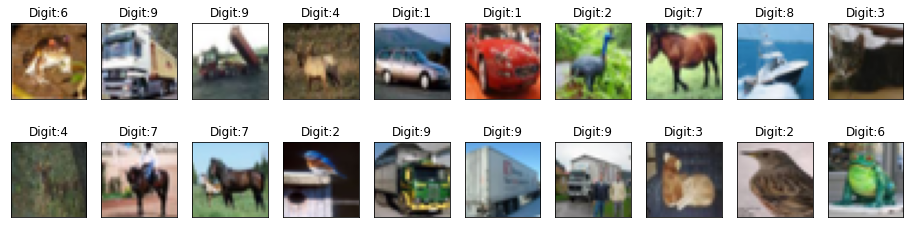

In [ ]:
#==================#
#    Plot data     #
#==================#
X = X_train + train_mean
Y = Y_train

fig = plt.figure(figsize = (16,4) )
for i in range(20):
  plt.subplot(2, 10, i+1)
  plt.imshow(X[i])
  plt.title('Digit:{}'.format(Y[i]))
  plt.xticks([])
  plt.yticks([])

del X, Y

## LeNet

Para esta arquitectura se revisaron varios blogs y demás donde usaban la arquitectura LeNet, pero en este [blog](https://bit.ly/3Sw2G73) se encuentra lo más parecida al paper original. Aunque no dice nada de la configuración para el entrenamiento, en el [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) original dicen que entrenan con una función de pérdida MSE y de optimizador SGD.

### Directory to save results

In [ ]:
#===========================#
# Directory to save results #
#===========================#
dir = "/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/03_QMC_LeNet/"

if(not os.path.exists(dir)):
  os.mkdir(dir)

dir = dir + "CIFAR-10/"
name_file = "lenet_qmc"

if(not os.path.exists(dir)):
  os.mkdir(dir)

print(dir)

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/03_QMC_LeNet/CIFAR-10/


### Callbacks configuration

In [ ]:
#=============================#
# Function to reduce the lr   #
#=============================#
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.001
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr

In [ ]:
#===================================#
#     Configuration of callbacks    #
#===================================#
## Early stopping
stop = EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 15,
        verbose = 0,
        mode = "auto",
        baseline = None,
        restore_best_weights = False)

## Checkpoint to save best model
checkpoint = ModelCheckpoint(filepath = dir,
                             monitor = 'val_loss',
                             verbose = 0,
                             save_best_only = True)

## Learning rate scheduler to reduce lr for some epochs
lr_scheduler = LearningRateScheduler(lr_schedule)

## Function to reduce the learning rate if it doesn't improve
lr_reducer = ReduceLROnPlateau(factor = 0.1, # np.sqrt(0.1)
                               cooldown = 0,
                               patience = 10,
                               min_lr = 0.5e-6)

## Join all the functions
callbacks = [lr_reducer] # lr_scheduler #  # 

### Data Augmentation

In [ ]:
#=======================#
#   Data Augmentation   #
#=======================#
datagen = ImageDataGenerator(
    ## Randomly shift images horizontally
    width_shift_range = 0.1,
    ## Randomly shift images vertically
    height_shift_range = 0.1,
    ## Randomly flip images
    horizontal_flip = True,         
    ## Fraction of images reserved for validation (strictly between 0 and 1)
    validation_split = 0.0)

## Train image generator
datagen.fit(X_dev)

### Trained LeNet Model

In [ ]:
model = load_model('/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/02_LeNet/CIFAR-10/model_3.h5', custom_objects={"maxECE_tf" : maxECE_tf, "cwECE_tf" : cwECE_tf})

## Copy model until the features extraction
lenet_features = Sequential()
for layer in model.layers[:-3]: 
    lenet_features.add(layer)

## Frozen the layers of LeNet
for l in lenet_features.layers:  
  l.trainable = False
  if l.name == "average_pooling2d":
    print (f"Name: {l.name}\t\t Trainable: {l.trainable}")
  elif l.name == "average_pooling2d_1":
    print (f"Name: {l.name}\t Trainable: {l.trainable}")
  else :  
    print (f"Name: {l.name}\t\t\t Trainable: {l.trainable}")

Name: conv2d			 Trainable: False
Name: average_pooling2d		 Trainable: False
Name: conv2d_1			 Trainable: False
Name: average_pooling2d_1	 Trainable: False
Name: flatten			 Trainable: False


### Parameter optimization

In [ ]:
#===============================#
# Grid of parameters to explore #
#===============================#
## Set seed 
n_seed = 260922
seed(n_seed)

## Grid of parameters
params = {'num_rff' : [2048,1024,512,256], 
          'gamma' : [2**-2,2**-3,2**-4,2**-5,2**-6,2**-7,2**-8,2**-9], 
          "n_comp1" : [128,256,512,1024] }
param_grid = list(ParameterGrid(params))

## Filter combinations where n_comp1 is higher than num_rff
param_grid = [param_grid[i] for i in range(len(param_grid)) if param_grid[i]["n_comp1"] <= param_grid[i]["num_rff"] ]

## Shuffle grid to select first n combinations
shuffle(param_grid)

print(f"Total number of combinations: {len(param_grid)}")

Total number of combinations: 104


In [ ]:
## Dataframe to store history results
his_full = pd.DataFrame()

## Fix parameters
random_state = 1284
n_experiments = 25
batch_size = 256
n_epochs = 200
dim_h = 10

In [ ]:
#=====================================#
#      Exploration of parameters      #
#=====================================#
## Continue loop # EN CASO DE QUE SEA CONTINUE TRUE, TOCA CAMBIAR DESDE DONDE A DONDE VAN LOS EXPERIMENTOS
continuar = True # False

if continuar:
    his_full = pd.read_csv(dir + "history_parameters.csv", index_col = 0)

for i in range(22, n_experiments):
  keras.backend.clear_session()

  ## Timestamp to get excecution time
  start_time = time.time()

  ## Explored parameters
  num_rff = param_grid[i]["num_rff"]
  gamma = param_grid[i]["gamma"]
  n_comp1 = param_grid[i]["n_comp1"]

  ####  Combine LeNet with QMC
  ## LeNet
  x = lenet_features.output

  ## Quantum Mapping (RFF)
  fm_x1 = layers.QFeatureMapRFF(x.shape[1], dim = num_rff, gamma = gamma, random_state = random_state, name = "q_feature_map_rff")
  psi_x = fm_x1(lenet_features.output)
  ones = tf.ones_like(x[:, 0:1])
  rho_x = tf.keras.layers.concatenate((ones, psi_x), axis=1)
  rho_x = tf.expand_dims(rho_x, axis=-1)

  ## First QMDM layer
  qmdmc1 = layers.QMClassifSDecompFDMatrix(dim_x = num_rff, dim_y = dim_h, n_comp = n_comp1, name = "QMDM_1") # dim_y = dim_h
  rho_h = qmdmc1(rho_x)

  ## Calculations to obtain the probabilities
  y_w = rho_h[:, 0, :]
  y_v = rho_h[:, 1:, :]
  probs = tf.einsum('...j,...ij,...ij->...i', y_w, y_v, tf.math.conj(y_v))
  qmdmclf2 = keras.Model(inputs = lenet_features.input, outputs = probs)

  ## Compile
  qmdmclf2.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate = lr_schedule(0)),  metrics=['accuracy'])

  ## Build model
  qmdmclf2.build(input_shape = (32,32,3))
  
  ## Fit the model on the batches generated by datagen.flow().
  history = qmdmclf2.fit(datagen.flow(X_dev, T_dev, batch_size = batch_size), validation_data = (X_val, T_val), epochs = n_epochs, verbose = 0, callbacks = callbacks)
  
  ## Arrange results of history
  his_aux = pd.DataFrame(history.history)
  his_aux["epochs"] = range(1,his_aux.shape[0]+1) 
  his_aux["rff_dim"] = num_rff
  his_aux["rff_gamma"] = gamma
  his_aux["rff_random_state"] = random_state  
  his_aux["qmdm1_ncomp"] = n_comp1  

  his_aux["train_acc_final"] = metrics.accuracy_score(y_true = Y_dev, y_pred = qmdmclf2.predict(X_dev).argmax(axis = 1))
  his_aux["val_acc_final"] = metrics.accuracy_score(y_true = Y_val, y_pred = qmdmclf2.predict(X_val).argmax(axis = 1))
  his_aux["test_acc_final"] = metrics.accuracy_score(y_true = Y_test, y_pred = qmdmclf2.predict(X_test).argmax(axis = 1))
  his_aux["parameter_seed"] = n_seed
  his_aux["experiment"] = i

  ## Append with past values
  his_full = his_full.append(his_aux)

  ## Export results
  his_full.to_csv(dir + "history_parameters.csv")
  del his_aux, x, fm_x1, psi_x, ones, rho_x, y_w, y_v, probs, qmdmclf2, history

  ## Clear keras backend
  keras.backend.clear_session()

  print(f"=======  Done: {i}; Duration (m): { (time.time() - start_time)/60:.3f}")
  del start_time

=======  Done: 22; Duration (m): 56.397
=======  Done: 23; Duration (m): 58.301
=======  Done: 24; Duration (m): 57.941


In [ ]:
## Read parameter history to check which combination was better
his_full = pd.read_csv(dir + "history_parameters.csv", index_col = 0)

## Select parameters of each combination and its results
his_full[['rff_dim', 'rff_gamma', 'rff_random_state', 'qmdm1_ncomp', 'train_acc_final','val_acc_final', 'test_acc_final','parameter_seed',"experiment"]]\
  .drop_duplicates()\
  .sort_values("val_acc_final", axis = 0, ascending=False)\
  .head()

,rff_dim,rff_gamma,rff_random_state,qmdm1_ncomp,train_acc_final,val_acc_final,test_acc_final,parameter_seed,experiment
0,2048,0.001953,1284,512,0.874267,0.6916,0.6815,260922,2
0,1024,0.001953,1284,512,0.804156,0.6806,0.6792,260922,8
0,1024,0.015625,1284,256,0.809956,0.6768,0.6704,260922,9
0,1024,0.001953,1284,1024,0.789889,0.6764,0.6749,260922,11
0,1024,0.007812,1284,1024,0.819156,0.6752,0.6764,260922,0


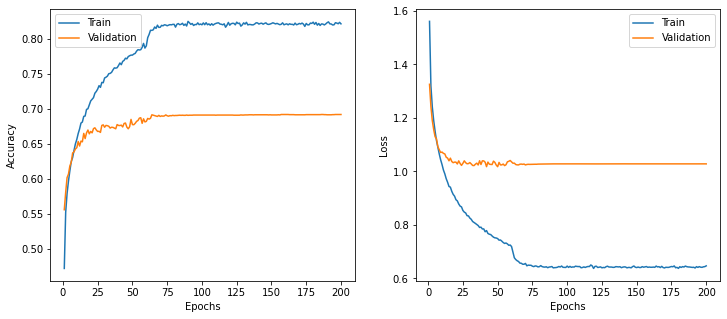

In [ ]:
## Number of best experiment
best_experiment = his_full.loc[his_full["val_acc_final"] == his_full["val_acc_final"].max(),"experiment"].unique()
best_experiment = best_experiment[0]

## Select best experiment
his_unique = his_full[his_full["experiment"] == best_experiment]

## Plot history of best experiment
fig, axis = plt.subplots(1,2, figsize = (12,5))

axis[0].plot(his_unique["epochs"], his_unique["accuracy"], label = "Train")
axis[0].plot(his_unique["epochs"], his_unique["val_accuracy"], label = "Validation")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracy")
axis[0].legend()

axis[1].plot(his_unique["epochs"], his_unique["loss"], label = "Train")
axis[1].plot(his_unique["epochs"], his_unique["val_loss"], label = "Validation")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Loss")
axis[1].legend()

plt.show()

### Training with best configuration of parameters

In [ ]:
#==========================================#
#    Configuration of best parameters      #
#==========================================#
batch_size = 256
n_epochs = 150

## Best parameters
num_rff = int(his_full.loc[his_full["experiment"] == best_experiment,"rff_dim"].unique()[0])
gamma = float(his_full.loc[his_full["experiment"] == best_experiment,"rff_gamma"].unique()[0])
n_comp1 = int(his_full.loc[his_full["experiment"] == best_experiment,"qmdm1_ncomp"].unique()[0])
random_state = int(his_full.loc[his_full["experiment"] == best_experiment,"rff_random_state"].unique()[0])

#===================================#
#     Configuration of callbacks    #
#===================================#
## Early stopping
stop = EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 15,
        verbose = 0,
        mode = "auto",
        baseline = None,
        restore_best_weights = True)

## Checkpoint to save best model
checkpoint = ModelCheckpoint(filepath = dir,
                             monitor = 'val_loss',
                             verbose = 0,
                             save_best_only = True)

## Learning rate scheduler to reduce lr for some epochs
lr_scheduler = LearningRateScheduler(lr_schedule)

## Function to reduce the learning rate if it doesn't improve
lr_reducer = ReduceLROnPlateau(factor = 0.1, # np.sqrt(0.1)
                               cooldown = 0,
                               patience = 10,
                               min_lr = 0.5e-6)

## Join all the functions
callbacks = [lr_reducer] # lr_scheduler # checkpoint

In [ ]:
## Clear session
keras.backend.clear_session()

## Timestamp to get excecution time
start_time = time.time()

####  Combine LeNet with QMC
## LeNet
x = lenet_features.output

## Number of classes
dim_h = np.unique(Y_train).shape[0]

## Quantum Mapping (RFF)
fm_x1 = layers.QFeatureMapRFF(x.shape[1], dim = num_rff, gamma = gamma, random_state = random_state, name = "q_feature_map_rff")
psi_x = fm_x1(lenet_features.output)
ones = tf.ones_like(x[:, 0:1])
rho_x = tf.keras.layers.concatenate((ones, psi_x), axis=1)
rho_x = tf.expand_dims(rho_x, axis=-1)

## First QMDM layer
qmdmc1 = layers.QMClassifSDecompFDMatrix(dim_x = num_rff, dim_y = dim_h, n_comp = n_comp1, name = "QMDM_1") # dim_y = dim_h
rho_h = qmdmc1(rho_x)

## Calculations to obtain the probabilities
y_w = rho_h[:, 0, :]
y_v = rho_h[:, 1:, :]
probs = tf.einsum('...j,...ij,...ij->...i', y_w, y_v, tf.math.conj(y_v))
qmdmclf2 = keras.Model(inputs = lenet_features.input, outputs = probs)

## Compile
qmdmclf2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.01),  metrics = ['accuracy', maxECE_tf, cwECE_tf])

## Build model
qmdmclf2.build(input_shape = X_train.shape[1:])

## Fit the model on the batches generated by datagen.flow().
history = qmdmclf2.fit(datagen.flow(X_dev, T_dev, batch_size = batch_size), validation_data = (X_val, T_val), epochs = n_epochs, verbose = 0, callbacks = callbacks)

## Results
his_aux = pd.DataFrame(history.history)
his_aux["epochs"] = range(1,his_aux.shape[0]+1) 
his_aux["rff_dim"] = num_rff
his_aux["rff_gamma"] = gamma
his_aux["rff_random_state"] = random_state  
his_aux["qmdm1_ncomp"] = n_comp1  

his_aux["train_acc_final"] = metrics.accuracy_score(y_true = Y_dev, y_pred = qmdmclf2.predict(X_dev).argmax(axis = 1))
his_aux["val_acc_final"] = metrics.accuracy_score(y_true = Y_val, y_pred = qmdmclf2.predict(X_val).argmax(axis = 1))
his_aux["test_acc_final"] = metrics.accuracy_score(y_true = Y_test, y_pred = qmdmclf2.predict(X_test).argmax(axis = 1))
his_aux["parameter_seed"] = n_seed

his_aux.head(5)

,loss,accuracy,maxECE_tf,cwECE_tf,val_loss,val_accuracy,val_maxECE_tf,val_cwECE_tf,lr,epochs,rff_dim,rff_gamma,rff_random_state,qmdm1_ncomp,train_acc_final,val_acc_final,test_acc_final,parameter_seed
0,1.603110,0.447956,0.104769,0.1,1.502300,0.4986,0.205812,0.1,0.01,1,2048,0.001953,1284,512,0.639022,0.6102,0.6133,260922
1,1.539264,0.481089,0.118143,0.1,1.452562,0.5062,0.205769,0.1,0.01,2,2048,0.001953,1284,512,0.639022,0.6102,0.6133,260922
2,1.523439,0.485067,0.117505,0.1,1.491046,0.5024,0.203487,0.1,0.01,3,2048,0.001953,1284,512,0.639022,0.6102,0.6133,260922
3,1.509039,0.491044,0.115890,0.1,1.460356,0.5158,0.207684,0.1,0.01,4,2048,0.001953,1284,512,0.639022,0.6102,0.6133,260922
4,1.498880,0.497267,0.115366,0.1,1.448854,0.5138,0.206871,0.1,0.01,5,2048,0.001953,1284,512,0.639022,0.6102,0.6133,260922


In [ ]:
#=====================#
# Calibration metrics #
#=====================#
gm_best, gm_ece_best, dmax_best, dcw_best = resume_metrics(X_test = X_test, Y_test = Y_test, T_test = T_test, model = qmdmclf2, nbins = 15)

In [ ]:
## Export history
his_aux = pd.read_csv(dir + "best_history_" + name_file + ".csv")

## Export calibration metrics
gm_best = pd.read_feather(dir + "global_metrics_best.feather")
gm_ece_best = pd.read_feather(dir + "global_metrics_ece_best.feather")
dmax_best = pd.read_feather(dir + "diagram_max_best.feather")
dcw_best = pd.read_feather(dir + "diagram_cw_best.feather")

In [ ]:
## Export history
his_aux.to_csv(dir + "best_history_" + name_file + ".csv")

## Export calibration metrics
gm_best.to_feather(dir + "global_metrics_best.feather")
gm_ece_best.to_feather(dir + "global_metrics_ece_best.feather")
dmax_best.to_feather(dir + "diagram_max_best.feather")
dcw_best.to_feather(dir + "diagram_cw_best.feather")

In [ ]:
## Select parameters of each combination and its results
his_aux[['train_acc_final', 'val_acc_final']]\
  .drop_duplicates()

,train_acc_final,val_acc_final
0,0.639022,0.6102


In [ ]:
## Global metrics calibration
gm_best

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum
0,0.52318,0.390411,1.153282,0.571679


In [ ]:
## Global metrics ECE
gm_ece_best

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.083599,0.014457,0.002863,0.0
1,Maximum,TV,Uniform,0.080901,0.011986,0.002805,0.0
2,CW,-,Uniform,0.019731,0.114705,0.000794,1.0


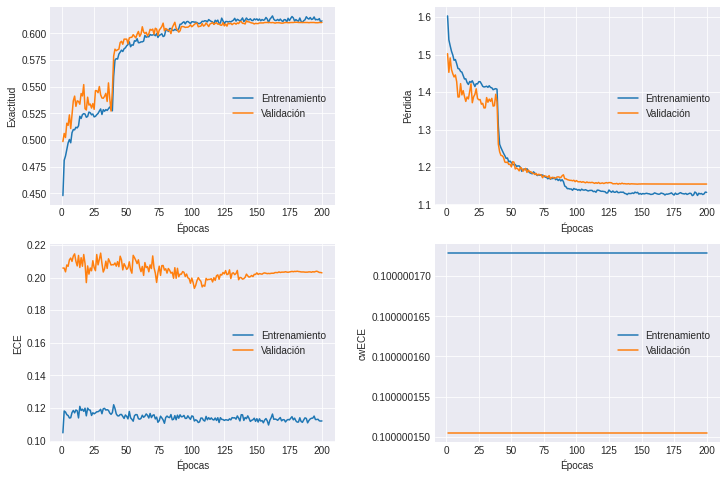

In [ ]:
plt.style.use('seaborn-darkgrid')

## Select best experiment
his_unique = his_aux

## Plot
fig, axis = plt.subplots(2,2, figsize = (12,8))

axis[0,0].plot(his_unique["epochs"], his_unique["accuracy"], label = "Entrenamiento")
axis[0,0].plot(his_unique["epochs"], his_unique["val_accuracy"], label = "Validación")
axis[0,0].set_xlabel("Épocas")
axis[0,0].set_ylabel("Exactitud")
axis[0,0].legend(loc = "center right")

axis[0,1].plot(his_unique["epochs"], his_unique["loss"], label = "Entrenamiento")
axis[0,1].plot(his_unique["epochs"], his_unique["val_loss"], label = "Validación")
axis[0,1].set_xlabel("Épocas")
axis[0,1].set_ylabel("Pérdida")
axis[0,1].legend(loc = "center right")

axis[1,0].plot(his_unique["epochs"], his_unique["maxECE_tf"], label = "Entrenamiento")
axis[1,0].plot(his_unique["epochs"], his_unique["val_maxECE_tf"], label = "Validación")
axis[1,0].set_xlabel("Épocas")
axis[1,0].set_ylabel("ECE")
axis[1,0].legend(loc = "center right")

axis[1,1].plot(his_unique["epochs"], his_unique["cwECE_tf"], label = "Entrenamiento")
axis[1,1].plot(his_unique["epochs"], his_unique["val_cwECE_tf"], label = "Validación")
axis[1,1].set_xlabel("Épocas")
axis[1,1].set_ylabel("cwECE")
axis[1,1].legend(loc = "center right")
axis[1,1].ticklabel_format(useOffset=False)

fig.subplots_adjust(wspace = 0.35)

#plt.show()
plt.savefig(dir + 'history_' + name_file + '.pdf', bbox_inches='tight')

del his_unique

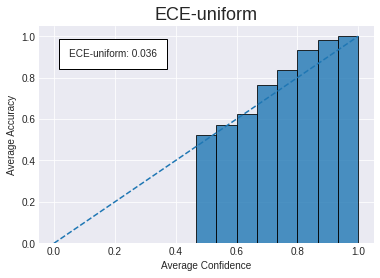

In [ ]:
## Reliability diagram (most confident prediction)
ReliabilityDiagram(dmax_best, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)
plt.savefig(dir + 'dmax_' + name_file + '.pdf', bbox_inches='tight')

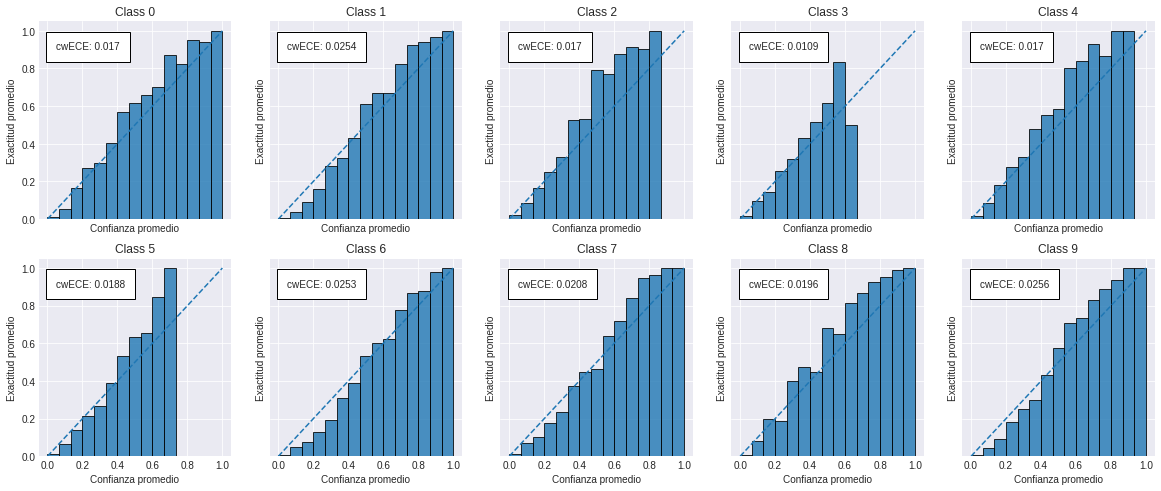

In [ ]:
## Reliability diagram (most confident prediction)
ReliabilityDiagram(dcw_best, diagram = "cw", nr_plt = 2, nc_plt = 5, w_plt = 20, h_plt = 8)
plt.savefig(dir + 'dcw_' + name_file + '.pdf', bbox_inches='tight')

In [ ]:
## Export model
qmdmclf2.save(dir + "best_model_" + name_file + ".h5")
qmdmclf2.count_params()

1878328

In [ ]:
## Import model
model = load_model(dir + 'model_' + name_file + '.h5')
model.count_params()
# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

62006